# Class 02 - Example

## Description of notebook

In this notebook, I will run you through the steps required to perform the exercise for class 2.
Here is a reminder of the instructions:
1. Create a folder called `group-x` within `nbs/class_02`, cd into it and work within that today
2. First, go back to your notebooks from last week, to remind yourself of what the data looks like
3. Secondly, choose which outcome variable you want to model. On the basis of this, define **which evaluation metric** could be suitable, and choose one:
    - We have mentioned metrics like RMSE, MAE, R-squared for regression
    - For classification, metrics like accuracy, precision/recall, or F1 scores will be relevant
    - All "classical" metrics can be computed using scikit-learn, if you don't want to implement them yourself;
4. (a) If you are in the bike sharing group, split your dataset into a training/validation/test set using later time points as validation/test set. Validation and test set should be 15% of your data each. (b) If you are in the personality group, using sklearn's `train_test_split` function, create a 75/15/15 random split of your data.
    - Remember to set a seed (`random_state`) when you do so. Let's all use the same (the classic `random_state=42`)
    - Save these datasets as separate csv files in a subfolder called `data`
5. Look at your outcome variable: do you want to transform it in any way?
5. Estimate the performance of your dummy baselines on all splits
6. Now look at your predictors: do they need any preprocessing? Any transformations? Removal of "bad" data points?
7. Fit your incremental models using KKN (sklearn's `KNeighborsRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) or linear models (`LinearRegressor`: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Save the fitted model object (with a meaningful name) using `pickle` (https://scikit-learn.org/stable/model_persistence.html) in a subfolder called `model`.
8. Once you are done, evaluate all models on both the training and the validation set
9. Bonus: if you have time, try to visualize if any pattern emerges


## Load Packages

In [4]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import itertools # to enumerate
import seaborn as sns

import pickle as pkl # to save model 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'matplotlib'

## Load data

First, let's load a dataset and do some basic data visualization. Our toy dataset includes 15 predictors for 17379 time points. The outcome variable `cnt` is a count of bike rentals.

In [2]:
data = pd.read_csv("/work/Project Files/data/class_01/bikes.csv")

## Inspect Data

In [3]:
display(data)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


Let's get some information abouts this dataset

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


All our variables are numerical. Let's get a sense for what their range is.

In [5]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Based on the above, it could seem as if `temp`, `atemp`, `hum` and `windspeed` have been min-max normalised (they all range from 0 to 1). 

In [6]:
data.season.unique()
# data.dteday.unique()

array([1, 2, 3, 4])

In [7]:
sns.pairplot(data[["temp","atemp","hum","windspeed","casual","registered","cnt"]])
plt.show()

In [ ]:
#Plotting box plot of continuous variables

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.boxplot(data["temp"])
plt.subplot(2,3,2)
plt.boxplot(data["atemp"])
plt.subplot(2,3,3)
plt.boxplot(data["hum"])
plt.subplot(2,3,4)
plt.boxplot(data["windspeed"])
plt.subplot(2,3,5)
plt.boxplot(data["casual"])
plt.subplot(2,3,6)
plt.boxplot(data["registered"])
plt.show()

In [ ]:
#Plotting box plot of categorical variables

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = data)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = data)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = data)
plt.subplot(3,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = data)
plt.subplot(3,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = data)
plt.subplot(3,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = data)
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = data)
plt.show()

In [ ]:

mpl.rc('font', size=14)       
mpl.rc('axes', titlesize=15)  
figure, axes = plt.subplots(nrows=3, ncols=2) 
plt.tight_layout()           
figure.set_size_inches(10, 9) 

sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])


axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')
axes[2, 0].set(title='Rental amounts by minute')
axes[2, 1].set(title='Rental amounts by second')

axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)

Let's take a look at the distribution of our outcome variable.

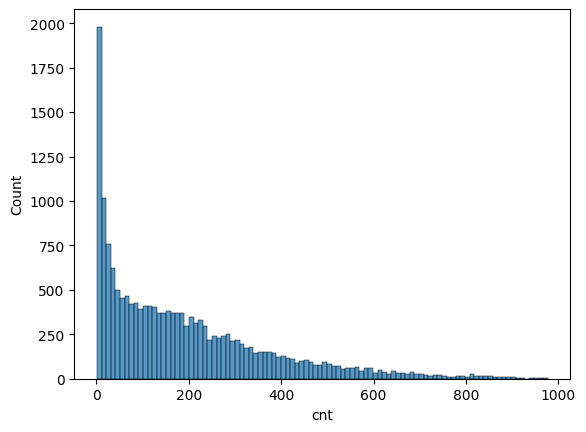

In [9]:
sns.histplot(data=data, x='cnt', binwidth=10)
plt.show()

The distribution is highly right-skewed. Values are concentrated at lower end and has a long tail extending to the right. This could lead to `heteroscedasticity` where the variance of the error terms is not constant across the range of the outcome variable, which can essentially violate the assumptions of linear regression models and potentially lead to biased estimates. What we could do is to do a log transformation or square root transformation...

In [ ]:
sns.displot(np.log(data['cnt']));

### Data Preparation

#### Removing unwanted columns

I want to drop the following columns:
- `instant` (just a sequence number of rows)
- `dteday`we don't need, we have cols for year and month already

In [ ]:
data.drop(columns=["instant","dteday"],axis=1,inplace =True)
data.head()

#### Dummy variables

In [ ]:
season_type = pd.get_dummies(data['season'], drop_first = True)
season_type.rename(columns={2:"season_summer", 3:"season_fall", 4:"season_winter"},inplace=True)
season_type.head()

In [ ]:
weather_type = pd.get_dummies(data['weathersit'], drop_first = True)
weather_type.rename(columns={2:"weather_mist_cloud", 3:"weather_light_snow_rain"},inplace=True)
weather_type.head()

In [ ]:
# concatenating new dummy variables to the main dataframe
data = pd.concat([data, season_type, weather_type], axis = 1)

# drop the columns season & weathersit since we have already created dummies for them

data.drop(columns=["season", "weathersit"],axis=1,inplace =True)

# check dataframe after dropping columns
data.info()

In [ ]:
# creating year_quarter derived columns from month columns.
# that last quarter has not been created since we need only 3 columns to define the four quarters.

data["Quarter_JanFebMar"] = data["mnth"].apply(lambda x: 1 if x<=3 else 0)
data["Quarter_AprMayJun"] = data["mnth"].apply(lambda x: 1 if 4<=x<=6 else 0)
data["Quarter_JulAugSep"] = data["mnth"].apply(lambda x: 1 if 7<=x<=9 else 0)

# dropping column mnth since we have already created dummies.

data.drop(columns=["mnth"],axis=1,inplace =True)
data["weekend"] = data["weekday"].apply(lambda x: 0 if 1<=x<=5 else 1)
data.drop(columns=["weekday"],axis=1,inplace =True)
data.drop(columns=["workingday"],axis=1,inplace =True)
data.head()


In [ ]:
data.info()

Let's take a look at the correlation structure of the dataset and at potential relations between predictors.

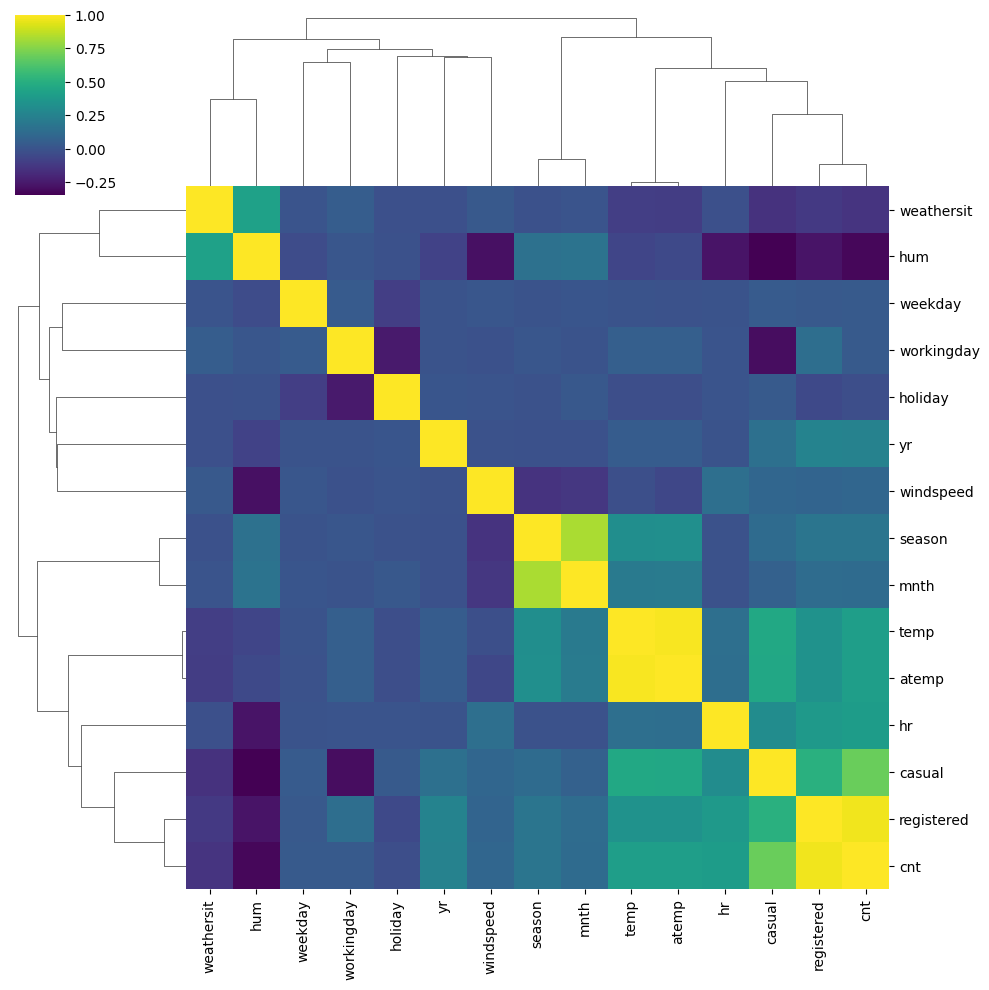

In [10]:
sns.clustermap(data.corr(), cmap='viridis')
plt.show()

There seem to be medium-strong correlations between our predictors, something to keep in mind for later when we will try to account for collinearities. Let's take a closer look at relations between our target and predictors.

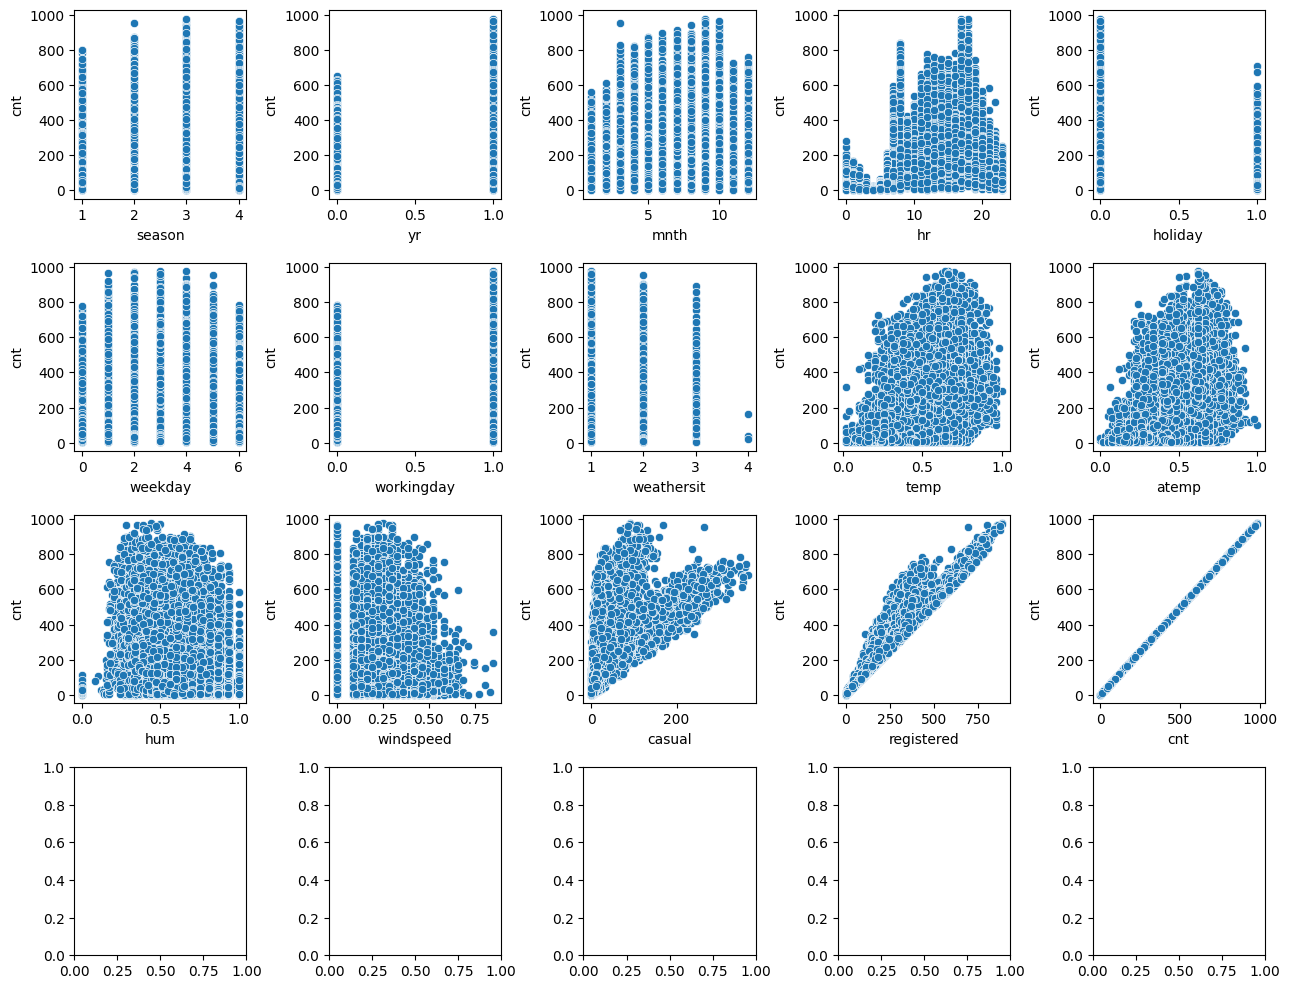

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(13,10))
plot_idx = list(itertools.product(range(5), range(5)))
for i,c in enumerate(data.columns):
    sns.scatterplot(data=data, x=c, y='cnt', ax=ax[plot_idx[i]])
plt.tight_layout()
plt.show()

## Choosing an evaluation metric

We are dealing with a regression problem where we care about knowing, in interpretable units, how off our predictions are. Big errors are kind of an issue here, so let's sacrifice some direct interpretability in favor of caution. We'll use RMSE.

## Train-dev-test split
Let's use scikit-learn's utils to create three data splits. First, we need to get our data to numpy arrays. This can be done easily in pandas. Note that we want to create 70/15/15 splits.

In [15]:
print("Index of 'cnt' column:", data.columns.get_loc('cnt'))

Index of 'cnt' column: 14


In [16]:
X = data.iloc[:,:14].values # all rows (:) and cols from 0 up to (but not including) index 14
y = data.iloc[:,14].values # all rows (:) and only the 14th column 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

# let's further split the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

Alright! Now let's save this data, so we can load it next time.

In [18]:
for x,y,name in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    df = pd.DataFrame(np.hstack([x,y.reshape(-1,1)]))
    df.columns = data.columns
    df.to_csv(f'bike_data_split/{name}.csv')

## Modelling

One of the questions asked in the exercise is whether we want to transform the data. In our case, we might be okay with no transformation and we might want to retain interpretability of the output. Let's make this assumption, and work on non-transformed data.

### Our models
Let's define a few models we want to estimate:
- Model 0: predicting the mean of the training data
- Model 1: predicting the `target` based on age, sex, and BMI and blood pressure
- Model 2: predicting the target based on measurements.

For Model 2, we will fit both KNN and linear regression models.

First, let's create a list where we will store performance data, and compute the performance of our baseline

In [19]:
performances = [] # list to store model performances 

### Model 0: Baseline, predicting mean of `cnt` in training data

In [20]:
mean_value = y_train.mean() # get the mean of cnt variable in train data
model_name = 'dummy'

for y,nsplit in zip([y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    performance = np.sqrt(mean_squared_error(y, 
                                             [mean_value]*y.shape[0]))
    r2 = r2_score(y, [mean_value]*y.shape[0])
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

### Model 1: Predict cnt from weather variables

Now let's fit a linear model with only weather predictors (those that seemed normalized)

In [21]:
reg = LinearRegression().fit(X_train[:, 9:13], y_train) # 9 = temp, 11 = hum, 12 = windspeed
pkl.dump(reg, file=open(f'bike-models/linear-weather.pkl', 'wb')) # save the model

In [22]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    preds = reg.predict(x[:,9:13])
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-weather',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

### Model 2: Predict cnt from only predictor: temp

In [23]:
temp_col = X_train[:, 9].reshape(-1, 1)  # reshape to maintain the 2D array shape expected by scikit-learn
reg = LinearRegression().fit(temp_col, y_train)
pkl.dump(reg,file=open(f'bike-models/linear-temp.pkl','wb'))

In [24]:
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # reshape input feature to a 2D array with one column
    temp_col = x[:,9].reshape(-1,1)

    preds = reg.predict(temp_col)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-temp',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

### Model 3: Predict cnt from all numeric predictors

In [25]:
# filter out non-numeric columns and the last column 'cnt' from X_train and X_test
numeric_cols = data.select_dtypes(include=np.number).columns[:-1]
numeric_cols_indices = [data.columns.get_loc(col) for col in numeric_cols]

X_train_numeric = X_train[:, numeric_cols_indices]
X_test_numeric = X_test[:, numeric_cols_indices]


In [26]:
# fit the model using all numeric predictors except 'cnt'
reg_all_numeric = LinearRegression().fit(X_train_numeric, y_train)
# Save the model
pkl.dump(reg_all_numeric, file=open(f'bike-models/linear-all-numeric.pkl', 'wb'))

In [27]:
# iterate over training, validation, and test sets to compute performance metrics
for x, y, nsplit in zip([X_train_numeric, X_val[:, numeric_cols_indices], X_test_numeric],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):

    preds = reg_all_numeric.predict(x)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': 'linear-all-numeric',
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

### Model 4: KNN model with weather variables (varying alphas)

In [28]:
for k in [3,5,10,20,30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train[:, 9:13], y_train)
    pkl.dump(neigh, file=open(f'bike-models/knn-weather-{k}.pkl','wb')) # save the model
    for x,y,nsplit in zip([X_train, X_val, X_test],
                        [y_train, y_val, y_test],
                        ['train', 'val', 'test']):
        preds = neigh.predict(x[:, 9:13]) 
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-weather-{k}',
                            'split': nsplit,
                            'rmse': performance.round(4),
                            'r2': r2.round(4)})

### Model 5: KNN model with all numeric predictors

And finally KNN models with all predictors

In [29]:
for k in [3, 5, 10, 20, 30]:
    neigh = KNeighborsRegressor(n_neighbors=k)
    neigh.fit(X_train_numeric, y_train)
    pkl.dump(neigh, file=open(f'bike-models/knn-all-num-preds-{k}.pkl', 'wb'))
    for x, y, nsplit in zip([X_train_numeric, X_val[:, numeric_cols_indices], X_test_numeric],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
        preds = neigh.predict(x)
        r2 = r2_score(y, preds)
        performance = np.sqrt(mean_squared_error(y, preds))
        performances.append({'model': f'knn-all-num-preds-{k}',
                             'split': nsplit,
                             'rmse': performance.round(4),
                             'r2': r2.round(4)})


## Plot performance of all the models

And finally, let's plot our performances.

In [30]:
perf_df = pd.DataFrame(performances)

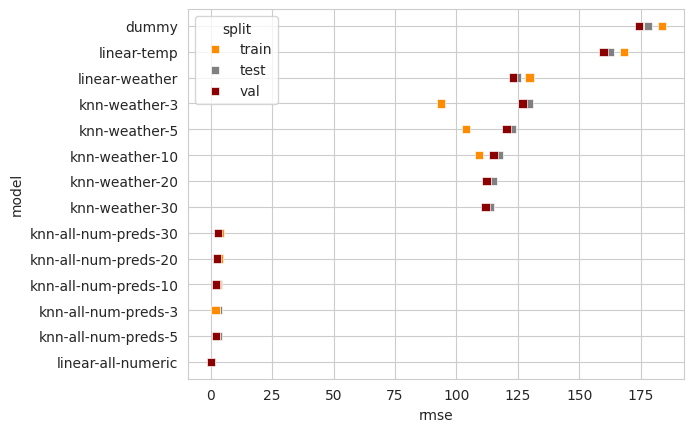

In [31]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

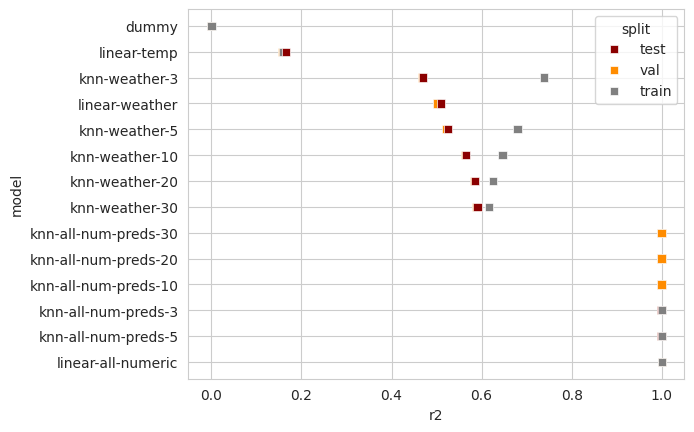

In [32]:
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=True), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkred', 'darkorange', 'grey'])
plt.show()

The knn-apreds-30, The knn-apreds-20, The knn-apreds-10, The knn-apreds-3, The knn-apreds-35, linear-all-numeric seem to be best, both in terms of having the lowest rmse on test set and the highest R2.

In [33]:
best_model = pkl.load(open('bike-models/knn-all-num-preds-5.pkl', 'rb'))

In [34]:
best_preds = best_model.predict(X_val)
absolute_error = np.abs(best_preds - y_val)

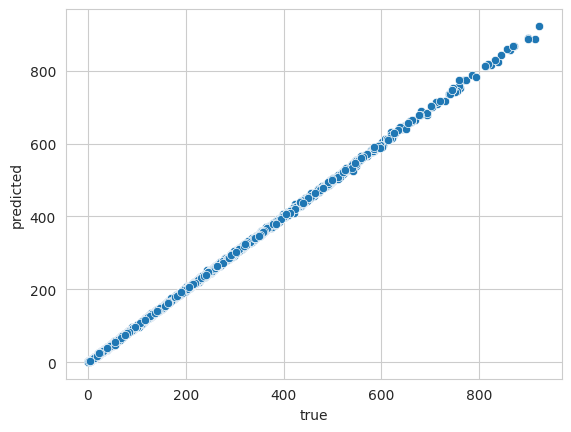

In [35]:
sns.scatterplot(x=y_val, y=best_preds)
plt.xlabel('true')
plt.ylabel('predicted')
plt.show()

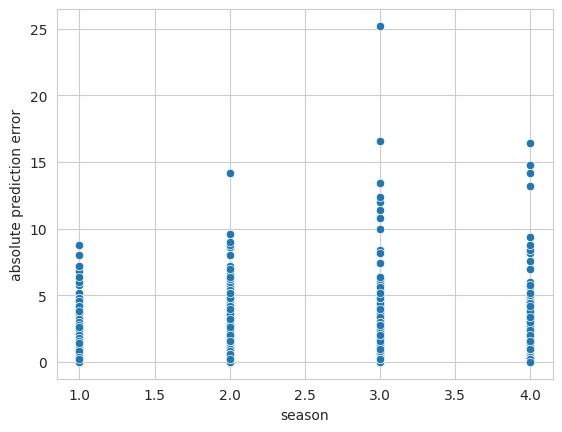

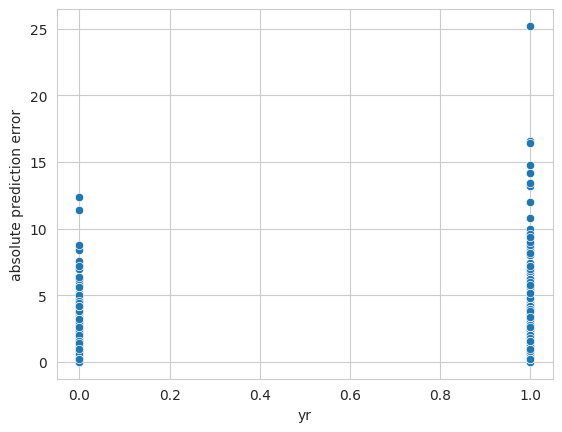

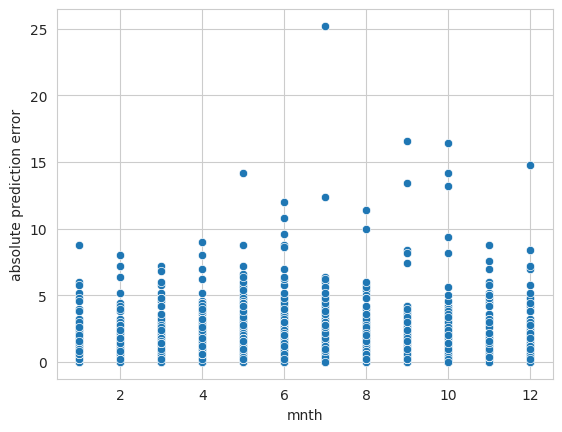

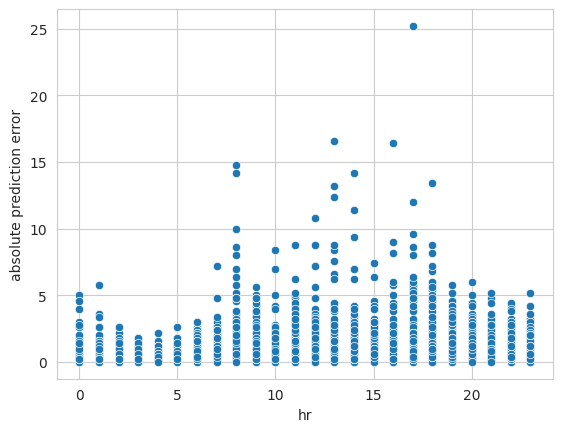

In [36]:
for i in range(4):
    sns.scatterplot(x=X_val[:,i], y=absolute_error)
    plt.xlabel(data.columns[i])
    plt.ylabel('absolute prediction error')
    plt.show()

There are no clear patterns in error types here, but for the sake of experience, let's try to add some polynomials and see how performance evolves!

### Adding polynomial features

In [37]:
from sklearn.preprocessing import PolynomialFeatures

for ionly in [True, False]:
    for deg in [2,3]:
        X_train_copy = X_train.copy()
        X_val_copy = X_val.copy()
        X_test_copy = X_test.copy()
        poly = PolynomialFeatures(deg, interaction_only=ionly)
        X_train_copy = poly.fit_transform(X_train_copy)
        X_val_copy = poly.fit_transform(X_val_copy)
        X_test_copy = poly.fit_transform(X_test_copy)
        reg = LinearRegression().fit(X_train_copy, y_train)
        for x,y,nsplit in zip([X_train_copy, 
                            X_val_copy, 
                            X_test_copy],
                            [y_train, y_val, y_test],
                            ['train', 'val', 'test']):
            preds = reg.predict(x)
            r2 = r2_score(y, preds)
            performance = np.sqrt(mean_squared_error(y, preds))
            performances.append({f'model': f'poly-allpreds-{deg}-intonly-{ionly}',
                                'split': nsplit,
                                'rmse': performance.round(4),
                                'r2': r2.round(4)})


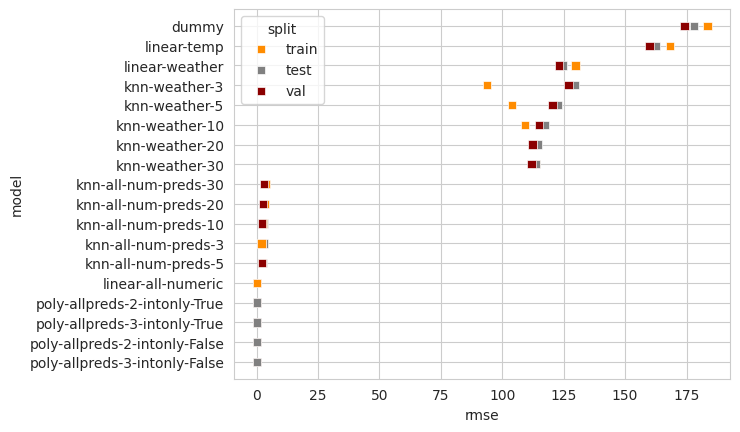

In [38]:
sns.set_style('whitegrid')
sns.scatterplot(data=pd.DataFrame(performances).sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

We don't see any clear performance advantage in adding polynomial features.